In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint

from mne.io import read_raw_brainvision as mne_read
from os.path import join
from os import listdir
import numpy as np

Using TensorFlow backend.


In [3]:
channels_num = 60
window_size = 500
nb_epoch = 50

# Hyper parameters
batch_size = 32
nb_visible = channels_num * window_size
nb_hidden = 1000
nb_emb = 20

corruption_level = 0.001

In [4]:
mne_format_data_dir = join('data', 'resting_state_mne_format')

In [5]:
def create_model():
    inp = Input(shape=(window_size, channels_num, 1))

    encoder = Sequential( [
        Conv2D(128, kernel_size=(5,5), activation='relu', padding='same', input_shape=(window_size,channels_num,1)),
        MaxPooling2D(),
        Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPooling2D(),
        Conv2D(1, kernel_size=(1,1), padding='same'),
    ] )
    print(encoder.summary())
    decoder = Sequential((
        Conv2D(128, kernel_size=(5,5), activation='relu', padding='same', input_shape=(125, 15, 1) ),
        UpSampling2D(),
        Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
        UpSampling2D(),
        Conv2D(1, kernel_size=(1,1), padding='same'),
    ))
    print(decoder.summary())
    autoencoder = Model(inp, decoder(encoder(inp)))
    autoencoder.compile(loss='mse', optimizer='adam', metrics=['mae'])

    print(autoencoder.summary())
    return autoencoder

In [6]:
autoencoder = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 500, 60, 128)      3328      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 250, 30, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 30, 64)       73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 15, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 15, 1)        65        
Total params: 77,185
Trainable params: 77,185
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
#scaler = StandardScaler()
mean, var = None, None

def cut_window(data):
    return data[:, :data.shape[1] - data.shape[1] % window_size]

def read_func(filename, verbose=0):
    d = mne_read(filename, verbose=verbose, preload=True)
    d.drop_channels(['VEOG', 'HEOG', 'STI 014'])
    d = d.get_data()
    return cut_window(np.vstack( [d, np.zeros( (2, d.shape[1]) )]) )

def read_data(data_type, return_batch_np=False):
    global mean, var
    ''' If return_batch_np is False
            return data with shape (None, batch_size, nb_visible)
        else number of batches in data
    '''
    verbose = None if return_batch_np else 0
    
    data_dir = join(mne_format_data_dir, data_type)
    data = np.hstack([read_func( join(data_dir, fn), verbose=verbose) for fn in listdir(data_dir) if fn[-5:] == '.vhdr'])
    
    if mean is None:
        mean, var = data.mean(), data.var()
    #data = scaler.transform(data)
    data = (data - mean) / (var ** (1/2))
    print(data_type, data.mean(), data.var())
    if return_batch_np:
        return data.shape[1] // window_size // batch_size
    return data.T.reshape(-1, window_size, channels_num, 1)

def gen(data_type):
    data = read_data(data_type)
    print(data.shape)
    for ep in range(nb_epoch+1):
        for i in range(data.shape[0] // batch_size):
            x = data[i*batch_size:(i+1)*batch_size, :, :, :]
            yield x, x

In [9]:
next(gen('train'))

train -6.34378883316e-16 1.0
(29879, 500, 60, 1)


(array([[[[-0.34265339],
          [ 0.07031351],
          [-0.22499868],
          ..., 
          [-0.36359731],
          [-0.11140064],
          [-0.11140064]],
 
         [[-0.34293028],
          [ 0.07011224],
          [-0.22517771],
          ..., 
          [-0.3636607 ],
          [-0.11140064],
          [-0.11140064]],
 
         [[-0.34322052],
          [ 0.06987315],
          [-0.22535897],
          ..., 
          [-0.36362845],
          [-0.11140064],
          [-0.11140064]],
 
         ..., 
         [[-0.34291805],
          [ 0.0695173 ],
          [-0.22572594],
          ..., 
          [-0.36324369],
          [-0.11140064],
          [-0.11140064]],
 
         [[-0.34231756],
          [ 0.06972636],
          [-0.22543904],
          ..., 
          [-0.36279665],
          [-0.11140064],
          [-0.11140064]],
 
         [[-0.34207736],
          [ 0.06995099],
          [-0.22520329],
          ..., 
          [-0.36214945],
          [-0.11140064],

In [10]:
train_batches_nb = read_data('train', return_batch_np=True)
val_batches_nb = read_data('validation', return_batch_np=True)

Extracting parameters from data/resting_state_mne_format/train/2505_shirokova_post_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 606599  =      0.000 ...   606.599 secs...
Extracting parameters from data/resting_state_mne_format/train/miloslavov_22_05_pre_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 603399  =      0.000 ...   603.399 secs...
Extracting parameters from data/resting_state_mne_format/train/gorin_rest_eeg_post_31011200.vhdr...
Setting channel info structure...
Reading 0 ... 603699  =      0.000 ...   603.699 secs...
Extracting parameters from data/resting_state_mne_format/train/2704_zagirova_post_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 604549  =      0.000 ...   604.549 secs...
Extracting parameters from data/resting_state_mne_format/train/2103_glebko_posteeg.vhdr...
Setting channel info structure...
Reading 0 ... 633899  =      0.000 ...   633.899 secs...
Extracting parameters from data/resting_state_mne_format/train/200317

In [11]:
history = autoencoder.fit_generator(gen('train'), steps_per_epoch=train_batches_nb, epochs=nb_epoch, \
                          validation_data=gen('validation'), validation_steps=val_batches_nb, \
                          #use_multiprocessing=True, \
                          callbacks=[ModelCheckpoint("models/cnn_%s_{epoch:02d}.hdf5"%str(nb_hidden), save_best_only=False)])

Epoch 1/50
train -6.34378883316e-16 1.0
(29879, 500, 60, 1)
932/933 [============================>.] - ETA: 0s - loss: 0.6052 - mean_absolute_error: 0.2604validation -0.164368573828 0.135983946103
(3149, 500, 60, 1)
933/933 [==============================] - 394s - loss: 0.6046 - mean_absolute_error: 0.2603 - val_loss: 0.1057 - val_mean_absolute_error: 0.2577
Epoch 2/50
933/933 [==============================] - 349s - loss: 0.5680 - mean_absolute_error: 0.2470 - val_loss: 0.0953 - val_mean_absolute_error: 0.2452
Epoch 3/50
933/933 [==============================] - 349s - loss: 0.5183 - mean_absolute_error: 0.2336 - val_loss: 0.0901 - val_mean_absolute_error: 0.2411
Epoch 4/50
933/933 [==============================] - 350s - loss: 0.5124 - mean_absolute_error: 0.2287 - val_loss: 0.0903 - val_mean_absolute_error: 0.2402
Epoch 5/50
933/933 [==============================] - 349s - loss: 0.5103 - mean_absolute_error: 0.2263 - val_loss: 0.0916 - val_mean_absolute_error: 0.2418
Epoch 6/50

Exception in thread Thread-51:
Traceback (most recent call last):
  File "/opt/conda/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
StopIteration



StopIteration: 

In [13]:
#test = next(gen('test'))

In [13]:
#test[0]

In [14]:
#autoencoder.predict(test[0])

In [9]:
test_batches_nb = read_data('test', return_batch_np=True)

Extracting parameters from data/resting_state_mne_format/test/zavrin_eyes_closed_eeg_15021500.vhdr...
Setting channel info structure...
Reading 0 ... 302749  =      0.000 ...   302.749 secs...
Extracting parameters from data/resting_state_mne_format/test/zavrin_15021500_eyesclosed_post_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 319299  =      0.000 ...   319.299 secs...
Extracting parameters from data/resting_state_mne_format/test/300120171600_dagaev_rest_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 615599  =      0.000 ...   615.599 secs...
Extracting parameters from data/resting_state_mne_format/test/tsoy_pre_eeg_2504.vhdr...
Setting channel info structure...
Reading 0 ... 652699  =      0.000 ...   652.699 secs...
test 5.32180965766e-17 1.0


In [10]:
import matplotlib.pyplot as plt
from keras.models import load_model
autoencoder = load_model('models/cnn_1000_06.hdf5')

In [11]:
autoencoder.evaluate_generator(gen('test'), steps=test_batches_nb)

test 5.32180965766e-17 1.0
(3779, 500, 60, 1)


[0.60504258853399151, 0.58064251835063352]

In [12]:
autoencoder.metrics_names

['loss', 'mean_absolute_error']

In [ ]:
history.history

In [ ]:
autoencoder.save('test.h5')

In [11]:
test = next(gen('test'))

In [47]:
test[0].shape

(64, 61)

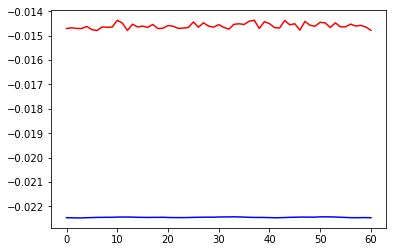

In [73]:
def show_test(n):
    plt.plot(np.arange(test[0][n].size), (test[0][n] * var ** (1/2) + mean).flatten(), color='b')
    res = autoencoder.predict(test[0][n].reshape(1, -1))
    plt.plot(np.arange(res.size), (res * var ** (1/2) + mean).flatten(), color='r')
    plt.show()
    
show_test(7)

In [76]:
test[0][0]

array([-1.19735468, -1.19766106, -1.1981571 , -1.19840395, -1.19839296,
       -1.19832731, -1.19817781, -1.19847933, -1.19851823, -1.19842214,
       -1.19833343, -1.1980574 , -1.19771942, -1.19723923, -1.19724166,
       -1.1972793 , -1.1971869 , -1.19685378, -1.19702642, -1.19726958,
       -1.19745194, -1.19777417, -1.19786414, -1.19775832, -1.19789935,
       -1.19814863, -1.19816809, -1.19852309, -1.1986118 , -1.19873707,
       -1.19857532, -1.19835892, -1.19795411, -1.19737783, -1.19721365,
       -1.19723554, -1.19742403, -1.19722338, -1.19716016, -1.19750058,
       -1.19784099, -1.19789332, -1.19791394, -1.1980076 , -1.19825076,
       -1.19836135, -1.19826535, -1.19845861, -1.19871762, -1.19881605,
       -1.19838566, -1.1978264 , -1.19747996, -1.1974143 , -1.19754075,
       -1.1975991 , -1.19777777, -1.1974143 , -1.19744465, -1.1975565 ,
       -1.19786171])

In [75]:
autoencoder.predict(test[0][0].reshape(1, -1))

array([[-0.81068474, -0.80941945, -0.81093025, -0.81085229, -0.80660617,
        -0.81327504, -0.81492221, -0.80790353, -0.80843753, -0.80828446,
        -0.79405653, -0.79962194, -0.81512022, -0.80202258, -0.80774528,
        -0.80601555, -0.80853337, -0.80269289, -0.81089044, -0.81020975,
        -0.80502218, -0.80605251, -0.81084102, -0.8100906 , -0.80870497,
        -0.79747999, -0.80827975, -0.79939252, -0.80619758, -0.80837649,
        -0.80311096, -0.80861604, -0.8124631 , -0.8023845 , -0.80139577,
        -0.80273634, -0.79608792, -0.7938416 , -0.81079549, -0.79689747,
        -0.80076027, -0.8090685 , -0.80986834, -0.79452288, -0.80349278,
        -0.80141538, -0.81425375, -0.79669464, -0.80475599, -0.80646384,
        -0.7984153 , -0.79969573, -0.80898458, -0.7993139 , -0.8075695 ,
        -0.80733687, -0.80190003, -0.80580699, -0.80462283, -0.80776191,
        -0.81464827]], dtype=float32)

In [26]:
autoencoder.evaluate_generator(gen('test'), steps=test_batches_nb)

0.0027330162475785683

```

```

```

```

```

```

```

```

```

```

```

```


# Далее код для дебага

In [ ]:
data = np.vstack([x[:, :x.shape[1]-(x.shape[1] % window_size)].T.reshape(-1, window_size, channels_num) for x in data])

In [ ]:
# DEBUG: this code is for debugging here, delete it or ignore
# scaler = StandardScaler()
# for el in data:  #DEBUG: iterate over all list
#     scaler.partial_fit(el.reshape(-1, 1))
# fir = scaler.transform(data[0].reshape(-1, 1))

#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1, nb_visible)

In [ ]:
i = 0
for el in gen(data_type='train'):
    i += 1

In [56]:
i

26

In [57]:
train_batches

235

In [58]:
val_batches

26

In [26]:
test_every

3

In [27]:
val_every

6

In [7]:
def f(x):
    for i in range(x):
        yield i
    

In [9]:
for e in f(7):
    print(e)

0
1
2
3
4
5
6


In [7]:
# Train
autoencoder.fit(x_train_noisy, x_train,
                nb_epoch=nb_epoch, batch_size=batch_size, shuffle=True, verbose=1,
                validation_split=0.1)

/home/mark/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 98845 samples, validate on 10983 samples
Epoch 1/15
98845/98845 [==============================] - 60s - loss: -2.5139 - val_loss: -2.7696
Epoch 2/15
98845/98845 [==============================] - 57s - loss: -2.7893 - val_loss: -2.8142
Epoch 3/15
98845/98845 [==============================] - 59s - loss: -2.8170 - val_loss: -2.8319
Epoch 4/15
98845/98845 [==============================] - 65s - loss: -2.8275 - val_loss: -2.8377
Epoch 5/15
98845/98845 [==============================] - 69s - loss: -2.8319 - val_loss: -2.8413
Epoch 6/15
98845/98845 [==============================] - 65s - loss: -2.8348 - val_loss: -2.8437
Epoch 7/15
98845/98845 [==============================] - 64s - loss: -2.8368 - val_loss: -2.8453
Epoch 8/15
98845/98845 [==============================] - 66s - loss: -2.8383 - val_loss: -2.8466
Epoch 9/15
98845/98845 [==============================] - 67s - loss: -2.8394 - val_loss: -2.8475
Epoch 10/15
98845/98845 [==============================] - 64s - los

In [8]:
autoencoder.save('autoenc_15ep.h5')

In [7]:
# Evaluate
evaluation = model.evaluate(X_test, Y_Test, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

 9920/10000 [============================>.] - ETA: 0s
Summary: Loss over the test dataset: 0.12, Accuracy: 0.98


In [54]:
# TESTING
eeg = mne.io.read_raw_brainvision(os.path.join(data_dir, fn)).get_data()

Extracting parameters from resting_state/post_eeg_tsoy_2504.vhdr...
Setting channel info structure...


In [60]:
el = eeg[:, :50]
el_sc = scaler.transform(el).reshape(1, -1)

In [62]:
(el.reshape(1, -1) - scaler.inverse_transform(autoencoder.predict(el_sc))).mean()

-0.00307421569033914

In [67]:
for e in el:
    print(e)


[-0.00360916 -0.00361387 -0.00361689 -0.00360994 -0.00359949 -0.00358958
 -0.00358601 -0.00358044 -0.00358398 -0.00358713 -0.00358159 -0.00358638
 -0.00359578 -0.00359912 -0.00360134 -0.00360818 -0.00360769 -0.0036105
 -0.00361348 -0.00361128 -0.00360068 -0.00360046 -0.00360051 -0.00358953
 -0.00357937 -0.00358054 -0.00357468 -0.00356375 -0.00357278 -0.00357795
 -0.00358372 -0.00359341 -0.00359719 -0.00360134 -0.0036009  -0.00359924
 -0.00360044 -0.00359529 -0.00359988 -0.00360706 -0.00360305 -0.00360081
 -0.00359814 -0.00360239 -0.00361304 -0.00361667 -0.00361108 -0.00360125
 -0.00360303 -0.00360442]
[-0.00066897 -0.0006707  -0.00067593 -0.00067092 -0.00065901 -0.00064861
 -0.00064778 -0.00064666 -0.00064683 -0.00064709 -0.00064106 -0.00064653
 -0.00066272 -0.00066138 -0.00066204 -0.00066785 -0.0006677  -0.00066646
 -0.00066841 -0.00066582 -0.00065947 -0.00065989 -0.00066062 -0.00065173
 -0.00064255 -0.00064285 -0.00064221 -0.00063796 -0.00064412 -0.00064861
 -0.00065066 -0.00065532 -

In [51]:
test = x_test

In [52]:
x = scaler.transform(test)
pred = autoencoder.predict(x)
pred = scaler.inverse_transform(pred)

In [53]:
(pred - test).mean()

0.005175371620944706

In [50]:
x_train.shape

(109828, 3050)

In [25]:
pred = autoencoder.predict(el)

In [ ]:
# Build autoencoder model with Conv2D
encoder = Sequential()
encoder.add(Conv2D(nb_hidden, kernel_size=(12, 12), activation = 'relu', input_shape=(batch_size,1, nb_visible,1), init='he_normal'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))
encoder.add(Conv2D(nb_hidden, kernel_size=(7, 7), activation = 'relu', init='he_normal'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))
encoder.add(Conv2D(nb_hidden, kernel_size=(5, 5), activation = 'relu', init='he_normal'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))
encoder.add(Conv2D(nb_hidden, kernel_size=(3, 3), activation = 'relu', init='he_normal'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))
#encoder.add(Flatten())
#encoder.add(Dense(180, activation = 'relu', init='he_normal'))
#encoder.add(Dropout(0.5))
#encoder.add(Dense(100, activation = 'relu', init='he_normal'))
#encoder.add(Dropout(0.5))
#encoder.add(Dense(nb_emb, activation = 'relu', init='he_normal'))

decoder = Sequential()
#decoder.add(Dense(nb_emb, activation = 'relu', init='he_normal'))
#decoder.add(Dropout(0.5))
#decoder.add(Dense(100, activation = 'relu', init='he_normal'))
#decoder.add(Dropout(0.5))
#decoder.add(Dense(180, activation = 'relu', init='he_normal'))
d#ecoder.add(Flatten())
decoder.add(UpSampling2D(pool_size=(2, 2)))
decoder.add(Conv2D(nb_hidden, kernel_size=(3, 3), activation = 'relu', init='he_normal'))
decoder.add(UpSampling2D(pool_size=(2, 2)))
decoder.add(Conv2D(nb_hidden, kernel_size=(5, 5), activation = 'relu', init='he_normal'))
decoder.add(UpSampling2D(pool_size=(2, 2)))
decoder.add(Conv2D(nb_hidden, kernel_size=(7, 7), activation = 'relu', init='he_normal'))
decoder.add(UpSampling2D(pool_size=(2, 2)))
decoder.add(Conv2D(nb_hidden, kernel_size=(12, 12), activation = 'relu', init='he_normal'))


input_img = Input(shape=(nb_visible,))
encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()


In [ ]:
# Multilayer Perceptron model
model = Sequential()
model.add(Dense(output_dim=625, input_dim=784, init=init_weights, activation='sigmoid', name='dense1'))
model.add(Dropout(prob_drop_input, name='dropout1'))
model.add(Dense(output_dim=625, input_dim=625, init=init_weights, activation='sigmoid', name='dense2'))
model.add(Dropout(prob_drop_hidden, name='dropout2'))
model.add(Dense(output_dim=10, input_dim=625, init=init_weights, activation='softmax', name='dense3'))
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()